# Deep Features Extraction

## Collect Data

In [2]:
from sklearn.metrics import cohen_kappa_score, accuracy_score
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam,SGD
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
#from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
from keras.applications.resnet50 import preprocess_input
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")




BATCH_SIZE=4

IMG_SIZE=224
historyfilename='model/history_model.json'
modelweights='model/model_weights.h5'

#The image names are found in the data-split folder
filename_train_covid='../Data-split/COVID/trainCT_COVID.txt'
filename_val_covid='../Data-split/COVID/valCT_COVID.txt'
filename_test_covid='../Data-split/COVID/testCT_COVID.txt'

filename_train_no_covid='../Data-split/NonCOVID/trainCT_NonCOVID.txt'
filename_val_no_covid='../Data-split/NonCOVID/valCT_NonCOVID.txt'
filename_test_no_covid='../Data-split/NonCOVID/testCT_NonCOVID.txt'


# In[5]:


path_covid='../Images-processed/CT_COVID/CT_COVID/'
path_non_covid='../Images-processed/CT_NonCOVID/CT_NonCOVID/'


# In[6]:



#prepare training data
with open(filename_train_covid) as f:
    covidimages_train_path = f.read().splitlines()

covidimages_train_path=[path_covid+s for s in covidimages_train_path]
covidclasses=[1]*len(covidimages_train_path)
print("Number of COVID images in train dataset is :"+ str(len(covidclasses)))

with open(filename_train_no_covid) as f:
    no_covidimages_train_path = f.read().splitlines()
non_covidimages_train_path=[path_non_covid+s for s in no_covidimages_train_path]
non_covidclasses=[0]*len(non_covidimages_train_path)
print("Number of Non COVID images in train dataset is :"+ str(len(non_covidclasses)))

trainpaths=covidimages_train_path+non_covidimages_train_path
Y_train=covidclasses+non_covidclasses

print("training samples :"+ str(len(Y_train)))


# In[7]:



#prepare val data
with open(filename_val_covid) as f:
    covidimages_val_path = f.read().splitlines()

covidimages_val_path=[path_covid+s for s in covidimages_val_path]
covidclasses=[1]*len(covidimages_val_path)
print("Number of COVID images in val dataset is :"+ str(len(covidclasses)))

with open(filename_val_no_covid) as f:
    no_covidimages_val_path = f.read().splitlines()
non_covidimages_val_path=[path_non_covid+s for s in no_covidimages_val_path]
non_covidclasses=[0]*len(non_covidimages_val_path)
print("Number of Non COVID images in val dataset is :"+ str(len(non_covidclasses)))

valpaths=covidimages_val_path+non_covidimages_val_path
Y_val=covidclasses+non_covidclasses

print("valing samples :"+ str(len(Y_val)))


# In[8]:



#prepare test data
with open(filename_test_covid) as f:
    covidimages_test_path = f.read().splitlines()

covidimages_test_path=[path_covid+s for s in covidimages_test_path]
covidclasses=[1]*len(covidimages_test_path)
print("Number of COVID images in test dataset is :"+ str(len(covidclasses)))

with open(filename_test_no_covid) as f:
    no_covidimages_test_path = f.read().splitlines()
non_covidimages_test_path=[path_non_covid+s for s in no_covidimages_test_path]
non_covidclasses=[0]*len(non_covidimages_test_path)
print("Number of Non COVID images in test dataset is :"+ str(len(non_covidclasses)))

testpaths=covidimages_test_path+non_covidimages_test_path
Y_test=covidclasses+non_covidclasses

print("testing samples :"+ str(len(Y_test)))


# In[9]:




def equalize_light(image, limit=2, grid=(16,16), gray=False):
    if (len(image.shape) == 2):
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        gray = True
    
    clahe = cv2.createCLAHE(clipLimit=limit, tileGridSize=grid)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))

    image = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    if gray: 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    return np.uint8(image)

def normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x 
    """
    min_val = np.min(x) #typically will be zero
    max_val = np.max(x) #typically will be 255
    x = (x-min_val) / (max_val-min_val)
    return x
def load_ben_color(path, sigmaX=10 ):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = equalize_light(image,3,(5,5))
    #image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
    image=normalize(image)  
    return image



N = len(trainpaths)
X_train = np.empty((N, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

for i, image_path in enumerate(tqdm(trainpaths)):
    X_train[i, :, :, :] = load_ben_color(image_path,sigmaX=10)


# In[14]:


print(X_train.shape)


# In[15]:


N_val = len(valpaths)
X_val = np.empty((N_val, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

for i, image_path in enumerate(tqdm(valpaths)):
    X_val[i, :, :, :] = load_ben_color(image_path,sigmaX=10)
print(X_val.shape)


# In[16]:


N_test = len(testpaths)
X_test = np.empty((N_test, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

for i, image_path in enumerate(tqdm(testpaths)):
    X_test[i, :, :, :] = load_ben_color(image_path,sigmaX=10)
print(X_test.shape)


Number of COVID images in train dataset is :191
Number of Non COVID images in train dataset is :234
training samples :425
Number of COVID images in val dataset is :60
Number of Non COVID images in val dataset is :58
valing samples :118
Number of COVID images in test dataset is :98
Number of Non COVID images in test dataset is :105
testing samples :203


100%|████████████████████████████████████████████████████████████████████████████████| 425/425 [00:07<00:00, 56.98it/s]


(425, 224, 224, 3)


100%|████████████████████████████████████████████████████████████████████████████████| 118/118 [00:02<00:00, 53.98it/s]


(118, 224, 224, 3)


100%|████████████████████████████████████████████████████████████████████████████████| 203/203 [00:03<00:00, 65.06it/s]


(203, 224, 224, 3)


## Import Extracted Features

In [3]:
import pickle

#with open("densenet121/extractedfeatures.pickle", "wb") as f:
#    pickle.dump((Train_Features,Train_Target,Val_Features,Val_Target,Test_Features,Test_Target,model,model_extracted), f)

with open("model/MondayDesneNet169/extractedfeatures.pickle", "rb") as f:
    Train_Features,Train_Target,Val_Features,Val_Target,Test_Features,Test_Target,model,model_extracted = pickle.load(f) 

## DenseNet169 output

In [4]:
preds = model.predict(X_test, verbose=2)
from sklearn.metrics import accuracy_score,f1_score,roc_curve,auc
print(accuracy_score(Y_test,np.round(preds)))
print(f1_score(Y_test,np.round(preds)))
fpr, tpr, thresholds = roc_curve(Y_test, preds)
print("AUC: " + str(auc(fpr, tpr)))

0.8177339901477833
0.7999999999999999
AUC: 0.893488824101069


In [177]:
history_dict={"val_loss": [0.696772575252137, 0.6585558827145624, 0.6454335567936048, 0.6306928070419926, 0.6117126420140266, 0.6026287649647665, 0.6113516310766592, 0.6152152169053837, 0.6128785925901542, 0.6011993593331111, 0.6085487874382633, 0.6294447097737911, 0.6269208786346144, 0.6625039528865936, 0.6580424450843011], "val_acc": [0.4830508474576271, 0.5508474576271186, 0.6186440677966102, 0.635593220338983, 0.6779661016949152, 0.652542372881356, 0.652542372881356, 0.6610169491525424, 0.6779661016949152, 0.6694915254237288, 0.6864406779661016, 0.6440677966101694, 0.635593220338983, 0.576271186440678, 0.635593220338983], "loss": [0.6678034757165348, 0.6354942083358764, 0.6066150115518009, 0.5896371598804698, 0.5928460635858424, 0.5879045981519363, 0.5714094462114222, 0.5669852565316593, 0.5545238468226265, 0.5410293680078843, 0.5407096536019269, 0.543673695676467, 0.5471876408072079, 0.5255815123109256, 0.5101646954873029], "acc": [0.5576470588235294, 0.64, 0.6658823529411765, 0.7011764705882353, 0.7035294117647058, 0.6635294117647059, 0.7223529411764706, 0.7082352941176471, 0.7058823529411765, 0.7435294117647059, 0.7341176470588235, 0.7388235294117647, 0.7294117647058823, 0.7435294117647059, 0.7552941176470588]}

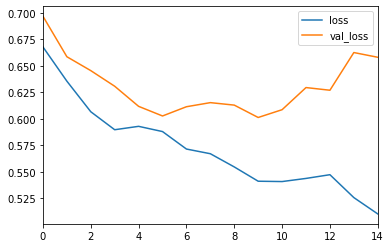

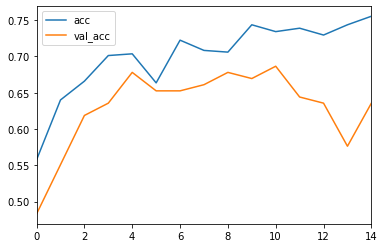

In [179]:
#historyfilename ='model/MondayDesneNet169/model_weights.h5'
#history_dict = json.load(open(historyfilename, 'r'))

history_df = pd.DataFrame(history_dict)
history_df.to_csv('history.csv')
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

## Accuracy function

In [180]:
from sklearn.metrics import confusion_matrix
def measure_per(y_val,preds,num_classes):
    print(accuracy_score(y_val,preds))
    print(cohen_kappa_score(y_val,preds))

    
    df_cm = pd.DataFrame(cm, range(num_classes),
                              range(num_classes))
    print(df_cm)

In [228]:
num_classes=2
# Creating a function to report confusion metrics
def confusion_metrics (truvalues,predictions):
# save confusion matrix and slice into four pieces
    conf_matrix = confusion_matrix(truvalues, predictions)
    df_cm = pd.DataFrame(conf_matrix, range(num_classes),
                              range(num_classes))
    print(df_cm)
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TN / float(TN + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*50)
    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f_1 Score: {round(conf_f1,2)}')

## XGBoost

In [327]:
from xgboost import XGBClassifier,XGBRegressor
from xgboost import plot_importance,plot_tree
eval_set = [(Val_Features, Val_Target)]

objective='binary:logistic'
eval_metric=["auc"]


xgb = XGBClassifier(objective=objective,
                   n_estimators=200,subsample=0.96,
                   max_depth=10,n_jobs=3)#binary:logistic

xgb.fit(Train_Features, Train_Target,eval_metric=eval_metric, eval_set=eval_set,verbose=False,early_stopping_rounds=50)

preds_xgb = xgb.predict(Test_Features)

from sklearn.metrics import accuracy_score,f1_score,roc_curve,auc
fpr, tpr, thresholds = roc_curve(Y_test, xgb.predict_proba(Test_Features)[:,1])
print("AUC: " + str(auc(fpr, tpr)))

AUC: 0.9033041788143829


In [467]:
confusion_metrics(Y_test,preds_xgb)

    0   1
0  91  14
1  13  85
True Positives: 85
True Negatives: 91
False Positives: 14
False Negatives: 13
--------------------------------------------------
Accuracy: 0.87
Mis-Classification: 0.13
Sensitivity: 0.87
Specificity: 0.87
Precision: 0.87
f_1 Score: 0.87


In [495]:
with open("bestXGBoostmodel.pickle", "wb") as f:
    pickle.dump((xgb), f)

## RF

In [238]:
bestmodel=rf

In [275]:
import pickle

#with open("bestRFmodel.pickle", "wb") as f:
#    pickle.dump((bestmodel), f)

In [447]:
with open("bestRFmodel/bestRFmodel.pickle", "rb") as f:
    rfa = pickle.load(f) 

In [448]:
rf=rfa

In [465]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=13, n_estimators=200)
rf.fit(Train_Features, Train_Target)
preds_rf = rf.predict(Test_Features)
fpr, tpr, thresholds = roc_curve(Y_test, rf.predict_proba(Test_Features)[:,1])
print("AUC: " + str(auc(fpr, tpr)))

AUC: 0.8974732750242953


In [466]:
confusion_metrics(Y_test,preds_rf)

    0   1
0  87  18
1  13  85
True Positives: 85
True Negatives: 87
False Positives: 18
False Negatives: 13
--------------------------------------------------
Accuracy: 0.85
Mis-Classification: 0.15
Sensitivity: 0.87
Specificity: 0.83
Precision: 0.83
f_1 Score: 0.85


In [468]:
imp_rf = rf.feature_importances_

(1664,)

## Bagging Decision Tree

In [358]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2,random_state=0)
bdt = BaggingClassifier(n_estimators=200,base_estimator=clf).fit(Train_Features, Train_Target)
#Predict the response for test dataset
preds_bdt = bdt.predict(Test_Features)

fpr, tpr, thresholds = roc_curve(Y_test, bdt.predict_proba(Test_Features)[:,1])
print("AUC: " + str(auc(fpr, tpr)))

AUC: 0.9015549076773567


In [359]:
confusion_metrics(Y_test,preds_bdt)

    0   1
0  86  19
1  11  87
True Positives: 87
True Negatives: 86
False Positives: 19
False Negatives: 11
--------------------------------------------------
Accuracy: 0.85
Mis-Classification: 0.15
Sensitivity: 0.89
Specificity: 0.82
Precision: 0.82
f_1 Score: 0.85


In [497]:
with open("bestbdtmodel.pickle", "wb") as f:
    pickle.dump((bdt), f)

## Adaboost

In [360]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=200)
clf.fit(Train_Features,Train_Target)
#Predict the response for test dataset
preds_adaboost = clf.predict(Test_Features)

fpr, tpr, thresholds = roc_curve(Y_test, clf.predict_proba(Test_Features)[:,1])
print("AUC: " + str(auc(fpr, tpr)))

AUC: 0.8350826044703596


In [361]:
confusion_metrics(Y_test,preds_adaboost)

    0   1
0  84  21
1  36  62
True Positives: 62
True Negatives: 84
False Positives: 21
False Negatives: 36
--------------------------------------------------
Accuracy: 0.72
Mis-Classification: 0.28
Sensitivity: 0.63
Specificity: 0.8
Precision: 0.8
f_1 Score: 0.71


In [498]:
with open("bestadaboostmodel.pickle", "wb") as f:
    pickle.dump((clf), f)

## GBDT

In [443]:
import lightgbm
train_data = lightgbm.Dataset(Train_Features, label=np.squeeze(Train_Target))
val_data = lightgbm.Dataset(Val_Features, label=np.squeeze(Val_Target))

parameters = {
    'objective': 'cross_entropy',
    'boosting': 'gbdt',#'gbdt' 'dart'
    'num_leaves': 21,
    'feature_fraction': 0.99,
    'bagging_fraction': 0.99,
    'bagging_freq': 30,  'learning_rate': 0.1,
    'verbose': 2,
}

gbm = lightgbm.train(parameters,
                       train_data,
                       valid_sets=val_data,
                       num_boost_round=1000,
                       early_stopping_rounds=100)



[1]	valid_0's xentropy: 0.680922
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's xentropy: 0.662609
[3]	valid_0's xentropy: 0.638034
[4]	valid_0's xentropy: 0.635319
[5]	valid_0's xentropy: 0.622174
[6]	valid_0's xentropy: 0.614138
[7]	valid_0's xentropy: 0.607836
[8]	valid_0's xentropy: 0.603123
[9]	valid_0's xentropy: 0.591247
[10]	valid_0's xentropy: 0.589585
[11]	valid_0's xentropy: 0.585327
[12]	valid_0's xentropy: 0.578837
[13]	valid_0's xentropy: 0.57855
[14]	valid_0's xentropy: 0.581009
[15]	valid_0's xentropy: 0.576708
[16]	valid_0's xentropy: 0.575278
[17]	valid_0's xentropy: 0.573405
[18]	valid_0's xentropy: 0.573272
[19]	valid_0's xentropy: 0.572891
[20]	valid_0's xentropy: 0.575715
[21]	valid_0's xentropy: 0.573019
[22]	valid_0's xentropy: 0.576273
[23]	valid_0's xentropy: 0.576701
[24]	valid_0's xentropy: 0.569728
[25]	valid_0's xentropy: 0.569666
[26]	valid_0's xentropy: 0.567626
[27]	valid_0's xentropy: 0.568559
[28]	valid_0's xentropy: 0.57

In [444]:
preds_gbdt=gbm.predict(Test_Features)
fpr, tpr, thresholds = roc_curve(Y_test, preds_gbdt)
print("AUC: " + str(auc(fpr, tpr)))

AUC: 0.9023323615160349


In [445]:
confusion_metrics(Y_test,np.round(preds_gbdt))

    0   1
0  90  15
1  18  80
True Positives: 80
True Negatives: 90
False Positives: 15
False Negatives: 18
--------------------------------------------------
Accuracy: 0.84
Mis-Classification: 0.16
Sensitivity: 0.82
Specificity: 0.86
Precision: 0.86
f_1 Score: 0.84


In [500]:
with open("bestlightgbmmodel.pickle", "wb") as f:
    pickle.dump((gbm), f)

## Dart

In [289]:
import lightgbm
train_data = lightgbm.Dataset(Train_Features, label=np.squeeze(Train_Target))
val_data = lightgbm.Dataset(Val_Features, label=np.squeeze(Val_Target))

parameters = {
    'objective': 'binary',
    'boosting': 'dart',#'gbdt' 'dart'
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 30,
    'verbose': 2,
}

dart = lightgbm.train(parameters,
                       train_data,
                       valid_sets=val_data,
                       num_boost_round=1000,
                       early_stopping_rounds=100)



[1]	valid_0's binary_logloss: 0.681957
[2]	valid_0's binary_logloss: 0.671843
[3]	valid_0's binary_logloss: 0.651553
[4]	valid_0's binary_logloss: 0.635626
[5]	valid_0's binary_logloss: 0.620932
[6]	valid_0's binary_logloss: 0.6112
[7]	valid_0's binary_logloss: 0.601755
[8]	valid_0's binary_logloss: 0.602437
[9]	valid_0's binary_logloss: 0.591426
[10]	valid_0's binary_logloss: 0.582238
[11]	valid_0's binary_logloss: 0.565282
[12]	valid_0's binary_logloss: 0.570528
[13]	valid_0's binary_logloss: 0.561578
[14]	valid_0's binary_logloss: 0.559752
[15]	valid_0's binary_logloss: 0.560612
[16]	valid_0's binary_logloss: 0.557724
[17]	valid_0's binary_logloss: 0.560193
[18]	valid_0's binary_logloss: 0.560525
[19]	valid_0's binary_logloss: 0.556087
[20]	valid_0's binary_logloss: 0.552506
[21]	valid_0's binary_logloss: 0.554106
[22]	valid_0's binary_logloss: 0.556701
[23]	valid_0's binary_logloss: 0.550505
[24]	valid_0's binary_logloss: 0.557925
[25]	valid_0's binary_logloss: 0.558272
[26]	valid_

[403]	valid_0's binary_logloss: 0.905057
[404]	valid_0's binary_logloss: 0.909214
[405]	valid_0's binary_logloss: 0.917771
[406]	valid_0's binary_logloss: 0.915099
[407]	valid_0's binary_logloss: 0.922397
[408]	valid_0's binary_logloss: 0.919255
[409]	valid_0's binary_logloss: 0.92567
[410]	valid_0's binary_logloss: 0.932489
[411]	valid_0's binary_logloss: 0.938688
[412]	valid_0's binary_logloss: 0.935562
[413]	valid_0's binary_logloss: 0.932205
[414]	valid_0's binary_logloss: 0.94035
[415]	valid_0's binary_logloss: 0.948593
[416]	valid_0's binary_logloss: 0.955435
[417]	valid_0's binary_logloss: 0.951389
[418]	valid_0's binary_logloss: 0.947746
[419]	valid_0's binary_logloss: 0.948102
[420]	valid_0's binary_logloss: 0.944977
[421]	valid_0's binary_logloss: 0.941573
[422]	valid_0's binary_logloss: 0.942651
[423]	valid_0's binary_logloss: 0.955305
[424]	valid_0's binary_logloss: 0.963742
[425]	valid_0's binary_logloss: 0.959851
[426]	valid_0's binary_logloss: 0.963506
[427]	valid_0's bi

[812]	valid_0's binary_logloss: 1.20042
[813]	valid_0's binary_logloss: 1.20619
[814]	valid_0's binary_logloss: 1.20452
[815]	valid_0's binary_logloss: 1.20985
[816]	valid_0's binary_logloss: 1.2145
[817]	valid_0's binary_logloss: 1.21249
[818]	valid_0's binary_logloss: 1.21476
[819]	valid_0's binary_logloss: 1.21322
[820]	valid_0's binary_logloss: 1.21104
[821]	valid_0's binary_logloss: 1.21366
[822]	valid_0's binary_logloss: 1.21166
[823]	valid_0's binary_logloss: 1.20987
[824]	valid_0's binary_logloss: 1.21178
[825]	valid_0's binary_logloss: 1.21216
[826]	valid_0's binary_logloss: 1.21063
[827]	valid_0's binary_logloss: 1.20874
[828]	valid_0's binary_logloss: 1.2104
[829]	valid_0's binary_logloss: 1.214
[830]	valid_0's binary_logloss: 1.21308
[831]	valid_0's binary_logloss: 1.21244
[832]	valid_0's binary_logloss: 1.21522
[833]	valid_0's binary_logloss: 1.22094
[834]	valid_0's binary_logloss: 1.21902
[835]	valid_0's binary_logloss: 1.21742
[836]	valid_0's binary_logloss: 1.21904
[837

In [407]:
preds_dart=dart.predict(Test_Features)
fpr, tpr, thresholds = roc_curve(Y_test, preds_dart)
print("AUC: " + str(auc(fpr, tpr)))

AUC: 0.897181729834791


In [408]:
confusion_metrics(Y_test,np.round(preds_dart))

    0   1
0  93  12
1  15  83
True Positives: 83
True Negatives: 93
False Positives: 12
False Negatives: 15
--------------------------------------------------
Accuracy: 0.87
Mis-Classification: 0.13
Sensitivity: 0.85
Specificity: 0.89
Precision: 0.89
f_1 Score: 0.87


In [501]:
with open("bestdartmmodel.pickle", "wb") as f:
    pickle.dump((dart), f)

# Cluster

In [471]:
# import KMeans
from sklearn.cluster import KMeans

In [489]:
# create kmeans object
kmeans = KMeans(n_clusters=3)
# fit kmeans object to data
kmeans.fit(Train_Features)
# print location of clusters learned by kmeans object
print(kmeans.cluster_centers_)

[[1.6134991e-03 2.1081895e-03 0.0000000e+00 ... 1.7568034e-01
  8.0918729e-02 2.6544614e+00]
 [8.0086337e-04 1.2054585e-03 1.5514814e-08 ... 8.4059513e-01
  1.2176312e+00 1.2046247e+00]
 [1.1649001e-03 1.4998619e-03 3.6504311e-08 ... 7.9408073e-01
  4.5360473e-01 1.0286644e+00]]


In [490]:
y_km = kmeans.fit_predict(Train_Features)

In [491]:
y_km

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 2, 2, 2, 2, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,

In [492]:
s = kmeans.fit_predict(Test_Features)

In [493]:
print(s)

[2 1 2 0 2 2 2 2 2 2 2 2 2 2 1 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 0 1 1
 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 2 2 0 2 2 2 0 1 1 2 2 2 2
 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0 2 2 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1
 1 1 1 1 1 1 0 1 1 1 1 1 0 2 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1
 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1]


In [518]:
np.round(preds_dart)

array([1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.])

# Check Features

In [512]:
import pandas as pd

In [520]:
di={'actual':Y_test,'preds_xgboost':preds_xgb,'preds_rf':preds_rf,
   'preds_bdt':preds_bdt,'preds_adaboost':preds_adaboost,'preds_gbdt':np.round(preds_gbdt),'preds_dart':np.round(preds_dart)}

In [521]:
df=pd.DataFrame(di)

In [522]:
df

,actual,preds_xgboost,preds_rf,preds_bdt,preds_adaboost,preds_gbdt,preds_dart
0,1,1,1,1,1,1.0,1.0
1,1,1,1,1,0,1.0,0.0
2,1,1,1,1,1,1.0,1.0
3,1,1,1,1,1,1.0,1.0
4,1,1,1,1,1,1.0,1.0
5,1,1,1,1,1,1.0,1.0
6,1,1,1,1,1,1.0,1.0
7,1,1,1,1,1,1.0,1.0
8,1,1,1,1,1,1.0,1.0
9,1,1,1,1,0,0.0,1.0
